In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
from jax import random, vmap
from jax.scipy.stats import norm
import numpyro.distributions as dist
from jax.scipy.special import gammaln
from astropy.cosmology import WMAP9 as cosmo
from scipy.optimize import curve_fit, brentq

In [2]:
array = np.array([1,2,3])
array1 = np.array([1,2,3,4])
array2 = np.array([1,2,3,4,5])
array1 = array1[:,None]
array2 = array2[:,None,None]
print((array+array1+array2).shape)
print()

(5, 4, 3)



In [3]:
# Verify the installation
print("JAX version:", jax.__version__)
print("JAX is using CUDA:", jax.lib.xla_bridge.get_backend().platform)

# Enable 64-bit floating point precision
jax.config.update("jax_enable_x64", True)

# Verify the update
print("jax_enable_x64:", jax.config.read("jax_enable_x64"))

JAX version: 0.4.30
JAX is using CUDA: gpu
jax_enable_x64: True


In [4]:
# Check available devices
print("Available devices:", jax.devices())

# Simple CPU computation test
x = jnp.array([1.0, 2.0, 3.0])
y = jax.device_put(x, jax.devices('gpu')[0])
z = y ** 2
print("Computation result:", z)

Available devices: [cuda(id=0)]


2024-08-21 15:09:57.760373: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Computation result: [1. 4. 9.]


In [5]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [6]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

In [7]:
d_desi = Planck18.distmod(z_desi).value

In [8]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [9]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.4)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

42124


In [10]:
#apr_mag_g = apr_mag_g.astype(np.float64)
#apr_mag_g_err = apr_mag_g_err.astype(np.float64)
#k_gg = k_gg.astype(np.float64)

apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [11]:
new_z = np.linspace(2.3,2.4,2)
new_V = cosmo.comoving_volume(new_z).value
new_d = Planck18.distmod(new_z).value

new_z = new_z.astype(np.float64)
new_V = new_V.astype(np.float64)
new_d = new_d.astype(np.float64)

In [17]:
# Efficiency function
def efficiency(x, m0, b):
    eff = jnp.where(x < m0, 1, (x/m0)**(-b))
    return eff

# Normal PDF
def log_normal_pdf(x, mean, sigma):
    return  -0.5 * ((x - mean) / sigma)**2

# Log Poisson
def log_poisson(k, lam):
    log_P = k * jnp.log(lam) - lam - gammaln(k + 1)
    return log_P
'''
# Integral calculation
def integral_1(b, m0, m_obs, m_err, M_bol, x, k, d,z):
    # Calculate the numerator
    epsilon = 1e-10  # A small constant to prevent the numerator from becoming zero

    numerator = efficiency(m_obs, m0, b) * (normal_pdf(m_obs, M_bol + x + k + d, m_err)+epsilon)
    
    # Calculate the integration bounds
    start = M_bol + x + k + d - 3 * m_err
    end = M_bol + x + k + d + 3 * m_err
    
    # Generate new_m_obs for integration
    new_m_obs = jnp.array([jnp.linspace(s, e, 10) for s, e in zip(start, end)])
    # Calculate the integrand for the denominator
    #print((M_bol + x + k + d)[:,None].shape)
    
    integrand = efficiency(new_m_obs, m0,  b) * normal_pdf(new_m_obs, (M_bol + x + k + d)[:,None], m_err[:,None])
    #print(integrand.shape)
    denominator = jnp.trapezoid(integrand, new_m_obs, axis=1)
    
    # Calculate the term1 value
    term1 = jnp.log(numerator)-jnp.log(denominator)
    L = abs_mag_to_L(M_bol)
    term2 = jnp.log(get_phis(L, z, "shen20"))
    #print(numerator,denominator)
    return jnp.sum(term1+term2)
'''
def integral_1(b, m0, m_obs, m_err, M_bol, x, k, d,z):
    # Calculate the numerator
    #epsilon = 1e-10  # A small constant to prevent the numerator from becoming zero

    log_numerator = jnp.log(efficiency(m_obs, m0, b)) + log_normal_pdf(m_obs, M_bol - x + k + d, m_err)
    
    # Monte Carlo integration
    key = random.PRNGKey(0)  # Random key for reproducibility
    # Generate samples from the normal distribution
    new_m_obs_samples = random.normal(key, shape=(len(m_obs), 20)) * m_err[:,None] + (M_bol - x + k + d)[:,None]

    # Evaluate the integrand for the denominator
    integrand_samples = efficiency(new_m_obs_samples, m0, b)
    
    # Estimate the denominator using Monte Carlo integration
    denominator = jnp.mean(integrand_samples, axis=1)
    
    # Calculate the term1 value
    term1 = log_numerator-jnp.log(denominator)
    L = abs_mag_to_L(M_bol)
    term2 = jnp.log(get_phis(L, z, "shen20"))
    #print(numerator,denominator)
    return jnp.sum(term1+term2)
# N_pre function
def N_pre(m0,b,M_bol,k,x,new_d,new_z,new_V):
    new_M = jnp.linspace(M_bol.min(),M_bol.max(),20)
    new_L = abs_mag_to_L(new_M)
    integrand = 0.16*0.4*efficiency(new_M[:,None]-x+k.mean()+new_d,m0,b)*get_phis(new_L[:,None], new_z, "shen20")
    integral1 = jnp.trapezoid(integrand,new_M,axis=0)
    integral2 = jnp.trapezoid(integral1,new_V,axis=0)
    return integral2

def model(k,d,z,m_obs,m_err,N_obs,new_d,new_z,new_V):
    x = numpyro.sample('x', dist.Uniform(-3,-1))
    m0 = numpyro.sample('m0', dist.Uniform(17, 20))
    #a = 1  # Adjust the range as needed
    b = numpyro.sample('b', dist.Uniform(0, 30))
    
    M_bol = numpyro.sample('M_bol', dist.Uniform(-30, -18).expand(k.shape)) 

    # Define log_L (replace with the actual log likelihood computation)
    log_L = integral_1(b, m0, m_obs, m_err, M_bol, x, k, d,z) + log_poisson(N_obs,N_pre(m0,b,M_bol,k,x,new_d,new_z,new_V))
    #log_L = log_poisson(N_obs,N_pre(m0,a,b,M_bol,k,x,new_d,new_z,new_V))
    # Factor in the log likelihood
    numpyro.factor('log_L', log_L)

In [18]:
rng_key = random.PRNGKey(0)
# Sampler configuration
num_warmup, num_samples = 1000, 2000
i_start = 0
i_end = i_start+1000
# Initialize batch parameters for the entire datasetw

init_params = {
    'x': -1.80 * jnp.ones((1,)),  
    'm0': 18.54 * jnp.ones((1,)),
    #'a': 0.0128 * jnp.ones((1,)),
    'b': 7 * jnp.ones((1,)),
    #'c': 175605 * jnp.ones((1,)),
}

# Set up the NUTS sampler
kernel = NUTS(model, target_accept_prob=0.8)
#kernel = HMC(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1, jit_model_args=True, progress_bar=True)

# Run the sampler over thswwe entire dataset
#mcmc.run(rng_key, apr_mag_g, apr_mag_g_err, k_gg, apr_mag_r, apr_mag_r_err, k_rr, d,z, 22.5, init_params=init_params)
mcmc.run(rng_key, k_rr[i_start:i_end], d_desi[i_start:i_end],  z_desi[i_start:i_end], apr_mag_r[i_start:i_end], apr_mag_r_err[i_start:i_end],N_obs,new_d,new_z,new_V)
# Get samples
samples = mcmc.get_samples()
# Optionally, process or save your samples
print(samples)

[4.52100522e-07 3.84955120e-07]
[-0.4 -0.4]
Traced<ConcreteArray([4.52100522e-07 3.84955120e-07], dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array([4.52100522e-07, 3.84955120e-07], dtype=float64)
  tangent = Traced<ShapedArray(float64[2])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[2]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f26080f8f20>, in_tracers=(Traced<ShapedArray(float64[20,2]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float64[20]):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[1.63644458e-07 2.12477043e-07 2.30817915e-07 2.17406387e-07
  1.88132735e-07 1.56741819e-07 1.29041244e-07 1.06218776e-07
  8.78339120e-08 7.30906758e-08 6.12381274e-08 5.16602467e-08
  4.38735161e-08 3.75033225e-08 3.22597771e-08 2.79177790e-08
  2.43016158e-08 2.12733222e-08 1.87239208e-08]
 [1.42077457e-07 1.82166102e-07 1.95979325e-07 1.83660580e-07
  1.58740528e-07 1.32371089e-07 1.09166426e-07 9.00391210e-08
  7.46073616e-08 6.22095732e-08 5.

  0%|          | 0/3000 [00:00<?, ?it/s]

Traced<ShapedArray(float64[2])>with<JVPTrace(level=5/0)> with
  primal = Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=3/0)>
  tangent = Traced<ShapedArray(float64[2])>with<JaxprTrace(level=4/0)> with
    pval = (ShapedArray(float64[2]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f25e867d740>, in_tracers=(Traced<ShapedArray(float64[20,2]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float64[20]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float64[2,19]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float64[1,19]):JaxprTrace(level=4/0)>), out_tracer_refs=[<weakref at 0x7f25e868acc0; to 'JaxprTracer' at 0x7f25e868ac70>], out_avals=[ShapedArray(float64[2])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[20,2] b:f64[20] c:f64[2,19] d:f64[1,19]. let
    e:f64[19] = pjit[
      name=diff
      jaxpr={ lambda ; f:f64[20]. let
          g:f64[19] = slice[limit_indices=(20,) start_indices=(1,) strides=None] f
          h:f64[19] = slice[limit_indices=(19,) start_i

sample: 100%|██████████| 3000/3000 [27:09<00:00,  1.84it/s, 1023 steps of size 4.43e-03. acc. prob=0.94]


{'M_bol': Array([[-25.16736317, -25.54643903, -24.82495225, ..., -25.21493164,
        -26.50006975, -25.6848306 ],
       [-25.21502013, -25.55609495, -24.79646717, ..., -25.26175222,
        -26.50082173, -25.68291116],
       [-25.21846112, -25.53751448, -24.79028919, ..., -25.25981375,
        -26.50575342, -25.71182818],
       ...,
       [-25.18946152, -25.53017121, -24.80297722, ..., -25.23603289,
        -26.50301405, -25.685632  ],
       [-25.19273993, -25.55389547, -24.81754948, ..., -25.22629065,
        -26.49981559, -25.68747944],
       [-25.19284136, -25.56432714, -24.8298053 , ..., -25.25160632,
        -26.50095178, -25.69595361]], dtype=float64), 'b': Array([12.33993215, 24.59258148, 14.02870268, ..., 15.25963976,
       22.95998878, 22.30843228], dtype=float64), 'm0': Array([17.64417046, 19.12229654, 18.02912779, ..., 18.25638734,
       19.01678255, 18.98728988], dtype=float64), 'x': Array([-1.00000049, -1.00000154, -1.00000048, ..., -1.00000109,
       -1.0000004

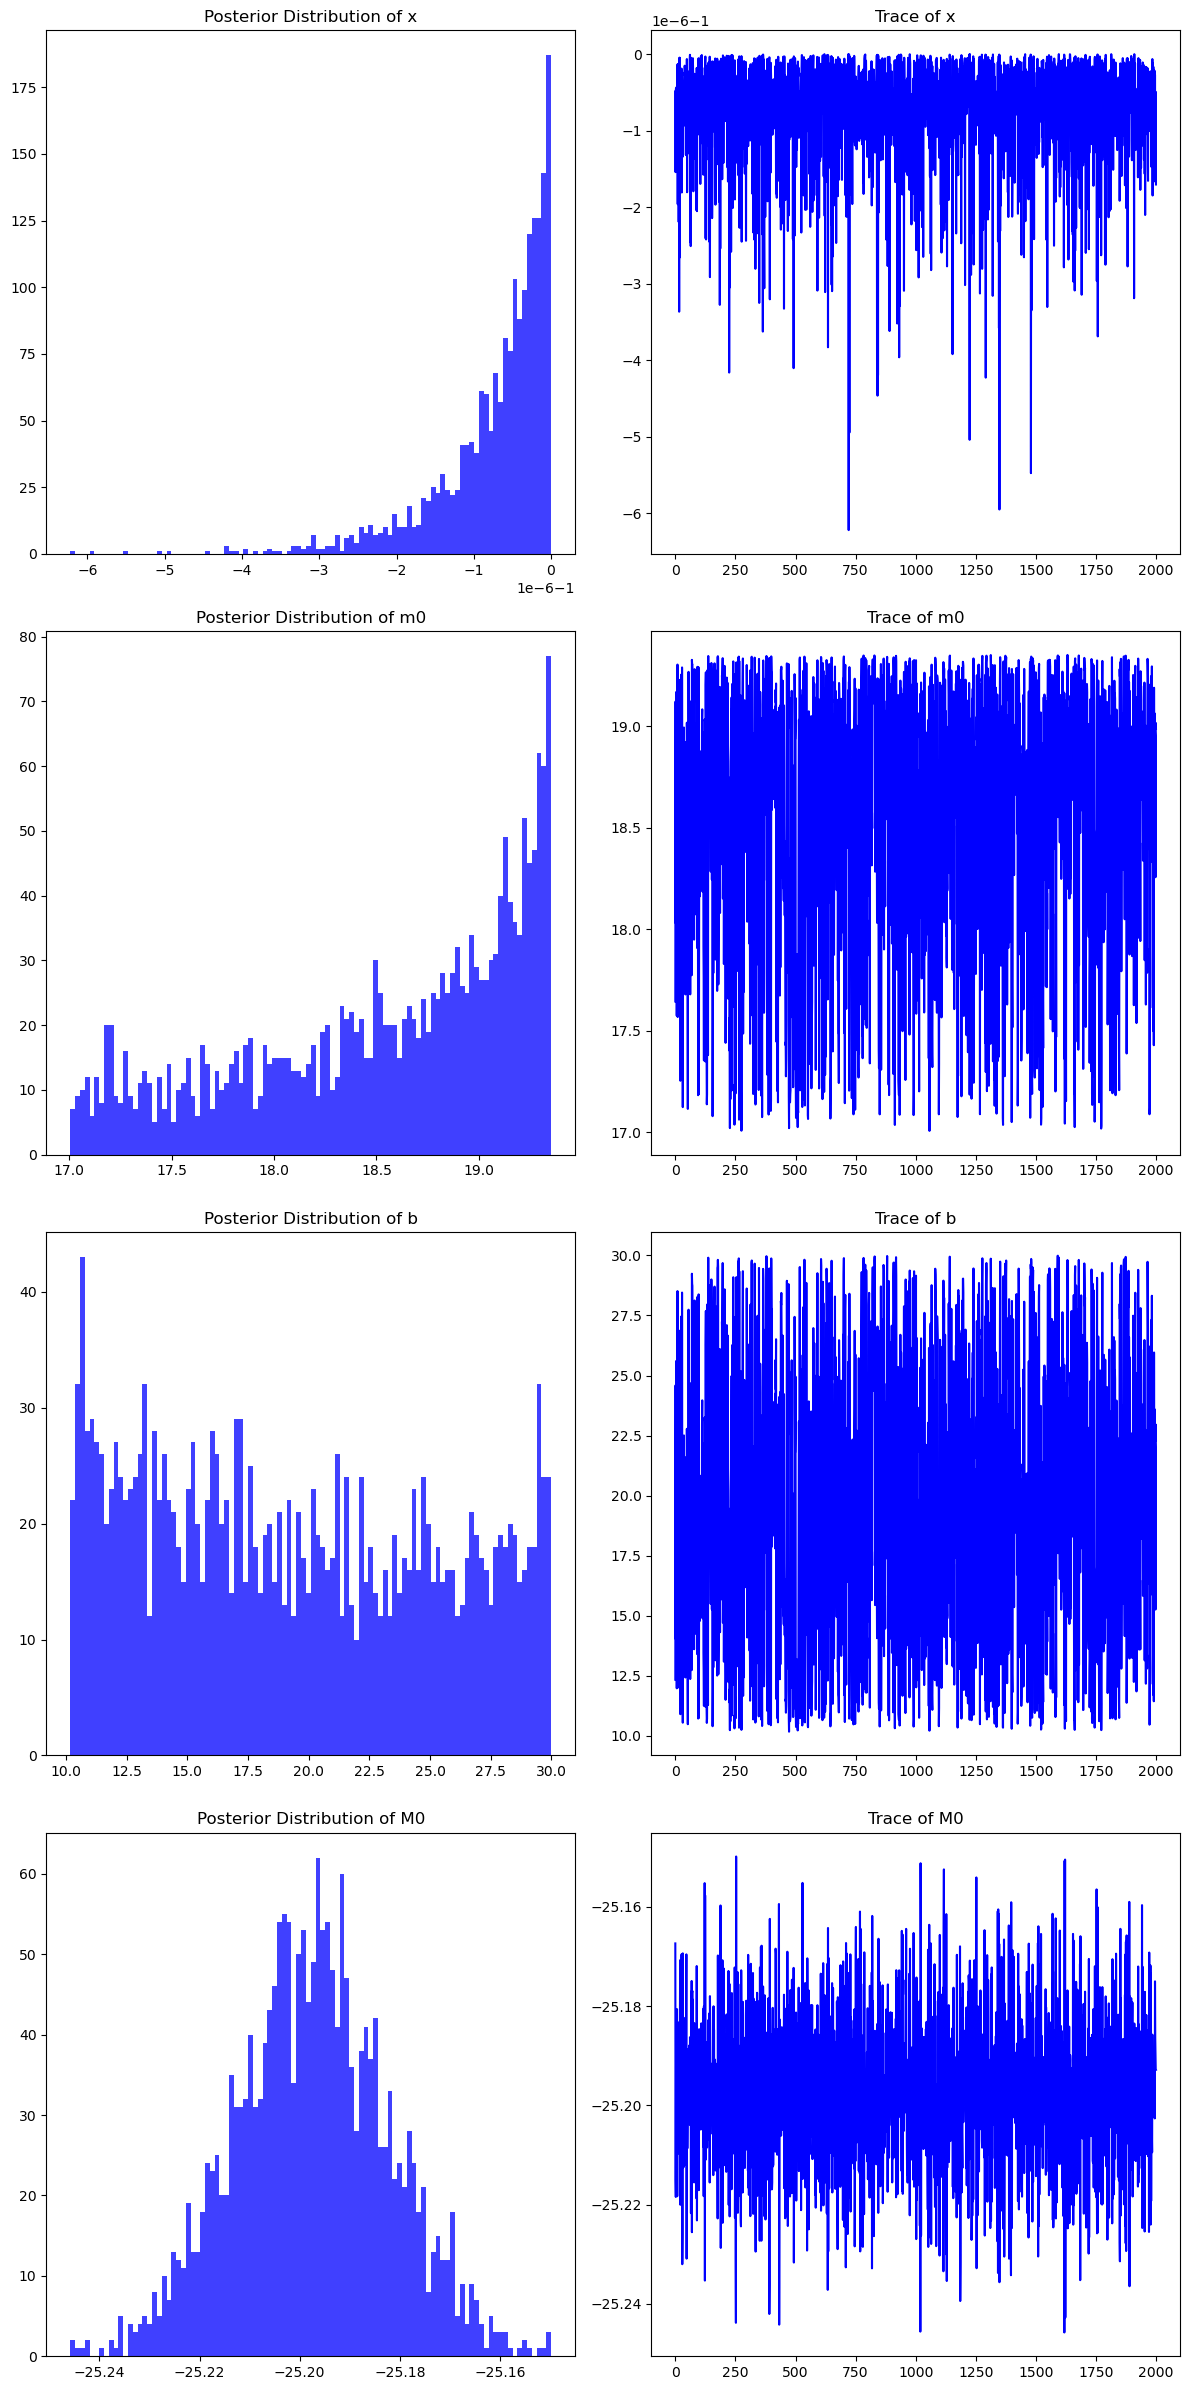

In [19]:
# Extract the chains and parameters
samples = mcmc.get_samples()
x = samples['x']
m0 = samples['m0']
#a = samples['a']
b = samples['b']
M0 = samples['M_bol'][:,0]
#c = samples['c']
# Creating a figure to hold the subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 24))  

# Helper function to plot histograms and traces
def plot_param(ax, data, title):
    ax[0].hist(data, bins=100, alpha=0.75, color='blue')
    ax[0].set_title(f'Posterior Distribution of {title}')
    ax[1].plot(data, color='blue')
    ax[1].set_title(f'Trace of {title}')

# Plotting each parameter
plot_param(axs[0], x, 'x')
plot_param(axs[1], m0, 'm0')
#plot_param(axs[2],a,'a')
plot_param(axs[2],b,'b')
plot_param(axs[3],M0,'M0')
#plot_param(axs[4],c,'c')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

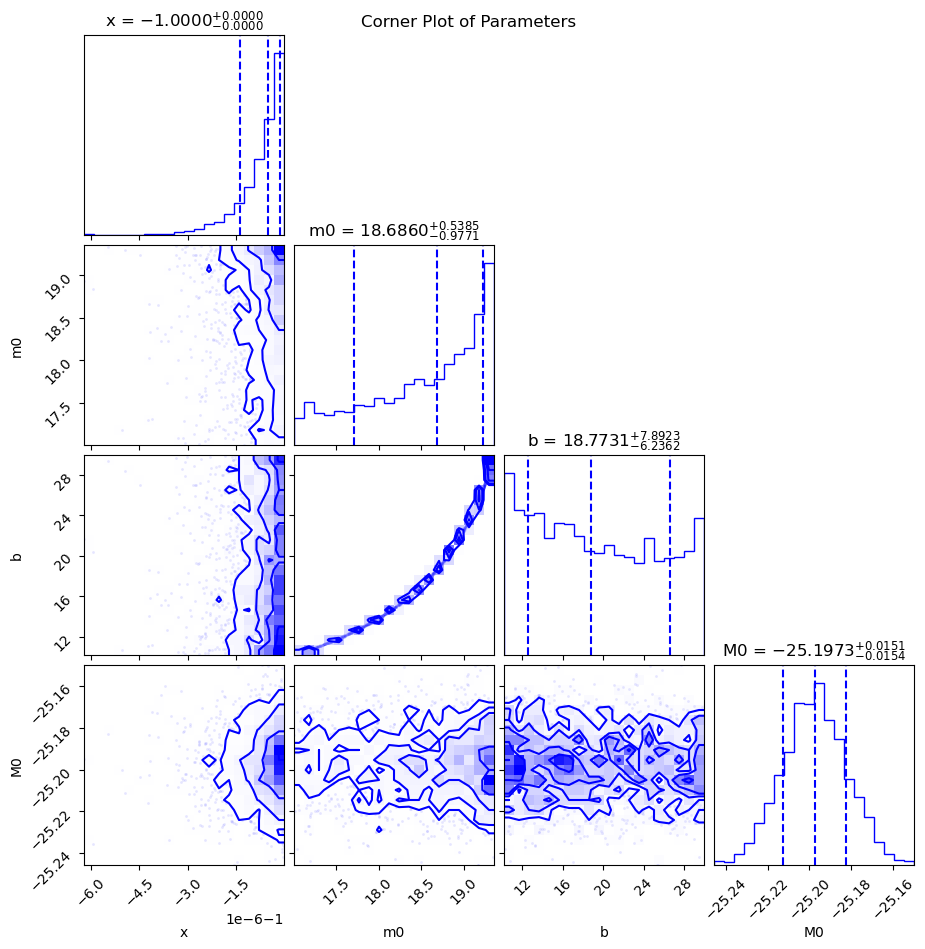

In [20]:
import corner
# Extract samples for plotting
#samples = np.vstack((x, m0)).T
samples = np.vstack((x,m0,b,M0)).T
# Create a corner plot
fig = corner.corner(samples, labels=['x', 'm0','b','M0'], 
                    show_titles=True,quantiles=[0.16, 0.5, 0.84],
                       plot_contours=True, color='blue', title_kwargs={"fontsize": 12},title_fmt=".4f")

fig.suptitle('Corner Plot of Parameters')
fig.show()

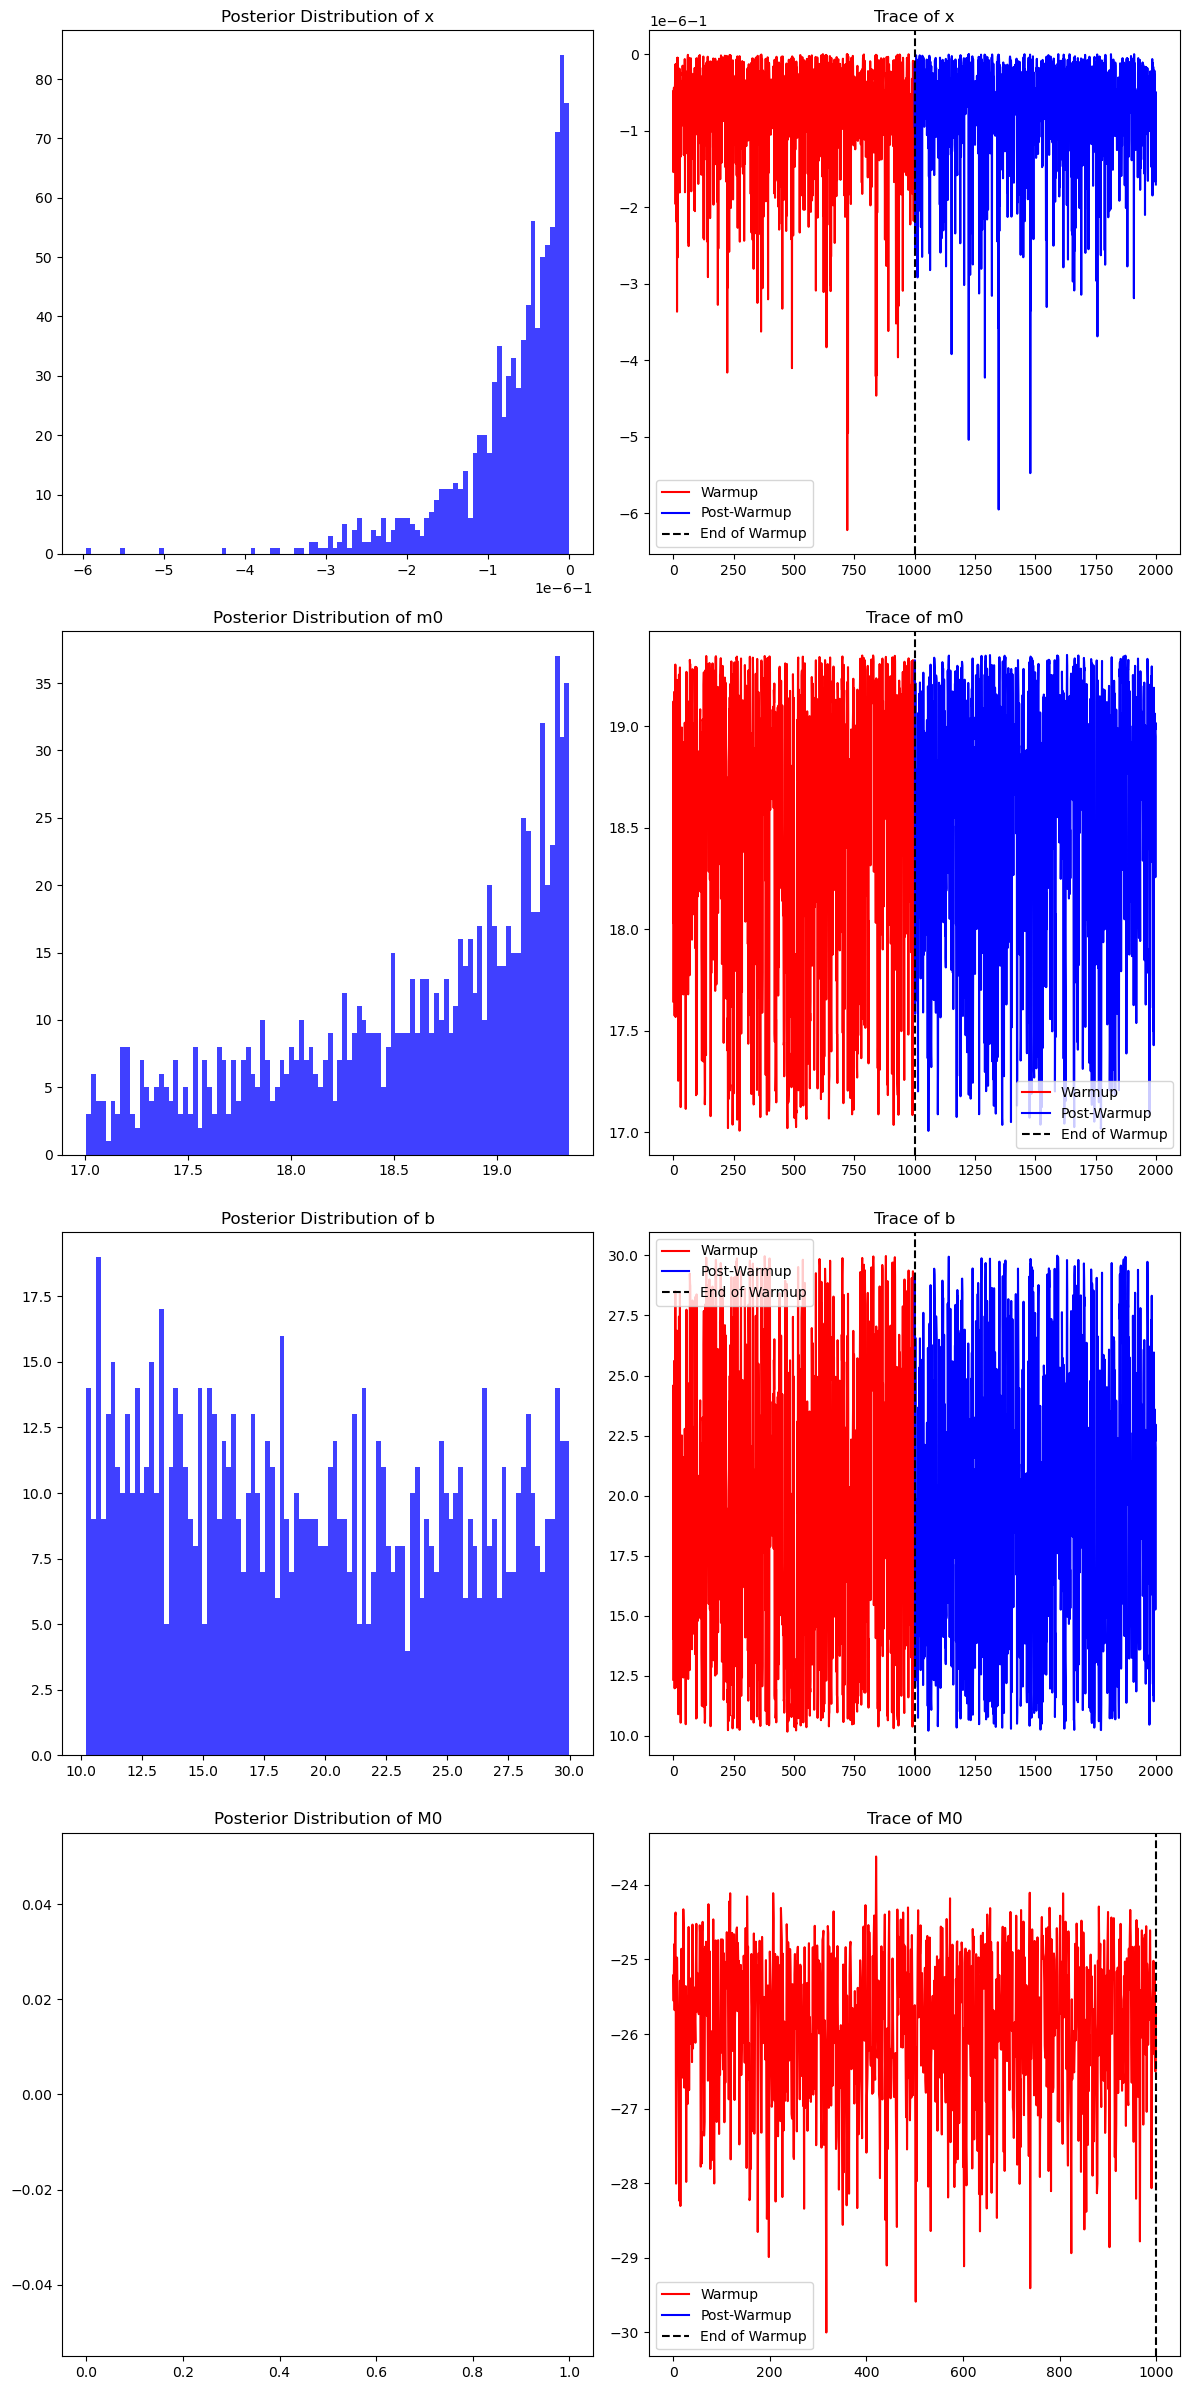

In [21]:
# Extract all chains, including warmup steps
all_samples = mcmc.get_samples(group_by_chain=True)

# Convert JAX arrays to NumPy arrays
all_samples = {k: np.array(v.block_until_ready()) for k, v in all_samples.items()}

# Number of warmup samples
num_warmup = mcmc.num_warmup

# Extract the parameter chains
x = all_samples['x'].flatten()
m0 = all_samples['m0'].flatten()
#a = all_samples['a'].flatten()
b = all_samples['b'].flatten()
M0 = all_samples['M_bol'][:,1].flatten()

# Creating a figure to hold the subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 24))

# Helper function to plot histograms and traces with warmup steps
def plot_param(ax, data, title):
    warmup_data = data[:num_warmup]
    post_warmup_data = data[num_warmup:]
    
    # Plot histogram of post-warmup samples
    ax[0].hist(post_warmup_data, bins=100, alpha=0.75, color='blue')
    ax[0].set_title(f'Posterior Distribution of {title}')
    
    # Plot trace with warmup steps in a different color
    ax[1].plot(range(num_warmup), warmup_data, color='red', label='Warmup')
    ax[1].plot(range(num_warmup, len(data)), post_warmup_data, color='blue', label='Post-Warmup')
    ax[1].set_title(f'Trace of {title}')
    ax[1].axvline(x=num_warmup, color='black', linestyle='--', label='End of Warmup')
    ax[1].legend()

# Plotting each parameter
plot_param(axs[0], x, 'x')
plot_param(axs[1], m0, 'm0')
#plot_param(axs[2], a, 'a')
plot_param(axs[2], b, 'b')
plot_param(axs[3], M0, 'M0')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()